![cover](https://images.unsplash.com/photo-1584714268709-c3dd9c92b378?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=799&q=80)

# 互联网新闻和消费者参与

在这个项目中，我们将探索我们的数据以发现模式，例如相关性、分布、平均值和时间序列分析。我们将使用文本回归和文本分类模型来预测基于标题的参与度分数和热门文章。 文本分类在我们日常使用的应用程序中很常见。例如，电子邮件提供商使用文本分类来过滤掉收件箱中的垃圾邮件。文本分类的另一个最常见的用途是在客户服务中，他们使用情感分析来区分差评和好评。我们将在标题上训练我们的模型，以便它可以预测文章在哪里排名靠前。 文本回归与此类似，我们采用文本矢量化数据并预测流行度分数，这是一个十进制值。

In [1]:
!pip install -q vaderSentiment
# !pip install -q wordcloud
# !pip install -U numpy==1.18.5


In [2]:
# Load packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud,STOPWORDS

from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_squared_error,f1_score,accuracy_score,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import NearMiss


plt.rc('figure',figsize=(8,7.5))

np.random.seed(2021)



In [3]:
print(f"Number of rows/records: {df.shape[0]}")
print(f"Number of columns/variables: {df.shape[1]}")
df.head()

Number of rows/records: 10437
Number of columns/variables: 14


,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN
3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0


In [4]:
NA = pd.DataFrame(data=[df.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
            for i in (df.isna().sum()/df.shape[0]*100).tolist()]], 
            columns=df.columns, index=['NA Count', 'NA Percent']).T.\
            sort_values(by='NA Count',ascending =False)
NA.style.background_gradient(cmap="summer", subset=['NA Count'])

,NA Count,NA Percent
content,1292,12.38%
author,1020,9.77%
url_to_image,656,6.29%
engagement_reaction_count,118,1.13%
engagement_comment_count,118,1.13%
engagement_share_count,118,1.13%
engagement_comment_plugin_count,118,1.13%
description,24,0.23%
title,2,0.02%
top_article,2,0.02%


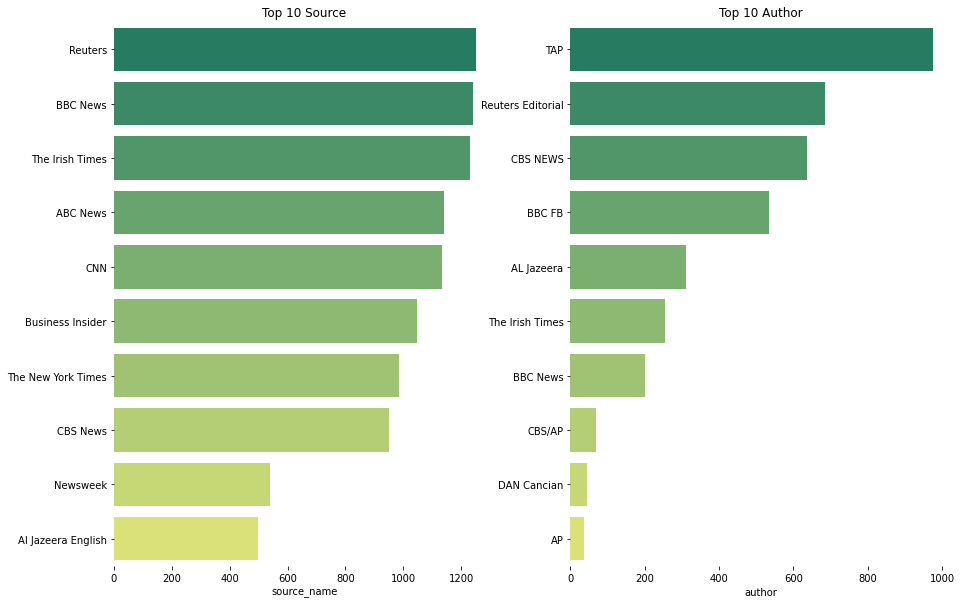

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
source_name = df["source_name"].dropna().value_counts()[:10]
author = df["author"].dropna().value_counts()[:10]

yticklabels = ['TAP',
               'Reuters Editorial',
               'CBS NEWS',
               'BBC FB',
               'AL Jazeera',
               'The Irish Times',
               'BBC News',
               'CBS/AP',
               'DAN Cancian', 
               'AP']
sns.barplot(x=source_name,y=source_name.index,palette='summer',ax=ax1)
sns.barplot(x=author,y=author.index,palette='summer',ax=ax2 )
sns.despine(bottom=True,left=True)
ax1.set(title='Top 10 Source')
ax2.set(title='Top 10 Author')
ax2.set_yticklabels(yticklabels) ;

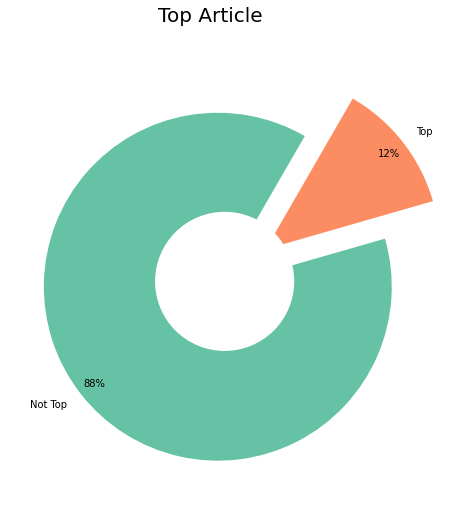

In [6]:
fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Top Article', size = 20, color = "black")
explode = ( 0.05, 0.3)
labels = ["Not Top","Top"]
sizes = df["top_article"].dropna().value_counts()
ax.pie(sizes, 
       explode=explode, 
       colors=sns.color_palette("Set2"),
       startangle=60,
       labels=labels,
       autopct='%1.0f%%',
       pctdistance=0.9)
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

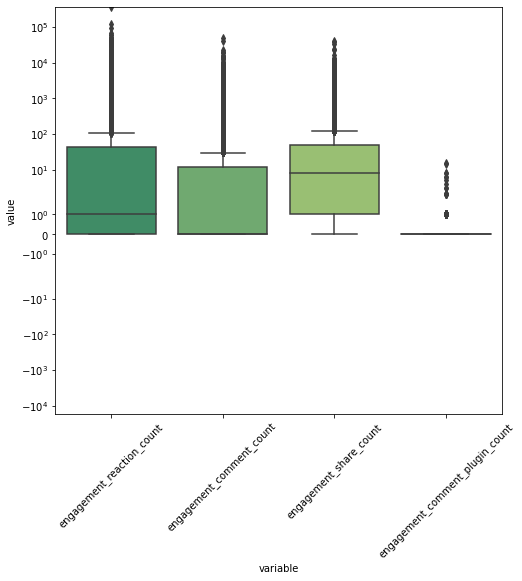

In [7]:
eng = ['engagement_reaction_count',
       'engagement_comment_count',
       'engagement_share_count',
       'engagement_comment_plugin_count'] 
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df[eng]),palette='summer')
plt.xticks(rotation=45)
ax.set_yscale('Symlog')
plt.show()

In [8]:
pd.DataFrame(df["engagement_comment_plugin_count"].\
             value_counts().\
             reset_index().\
             rename(columns = {'index':'engagement_comment_plugin',
                               'engagement_comment_plugin_count':'Counts'})).\
            astype(int).\
            style.background_gradient(cmap="summer", subset=['Counts'])

,engagement_comment_plugin,Counts
0,0,10269
1,1,32
2,2,8
3,6,2
4,8,2
5,3,2
6,15,1
7,5,1
8,4,1
9,14,1


In [9]:
df.published_at = pd.to_datetime(df.published_at)

df['Day_Of_Week'] = df.published_at.apply(lambda x: x.dayofweek)
df['Month'] = df.published_at.apply(lambda x: x.month)
df['Year'] = df.published_at.apply(lambda x: x.year)

In [10]:
df['title'][0:5]

0    NTSB says Autopilot engaged in 2018 California...
1         Unemployment falls to post-crash low of 5.2%
2    Louise Kennedy AW2019: Long coats, sparkling t...
3    North Korean footballer Han joins Italian gian...
4    UK government lawyer says proroguing parliamen...
Name: title, dtype: object

In [11]:
def clean_title(x:str):    
    # lowering the text
    x=x.lower() 
 
    #removing square brackets
    x = re.sub('\[.*?\]', '', x)
    x = re.sub('<.*?>+', '', x) 

    #removing hyperlink
    x = re.sub('https?://\S+|www\.\S+', '', x) 

    #removing puncuation
    x = re.sub('[%s]' % re.escape(string.punctuation), '', x) 
    x = re.sub('\n', '', x) 

    #remove words containing numbers
    x = re.sub('\w*\d\w*', '', x) 
    return x

In [12]:
df['clean_title'] = df['title'].astype(str).apply(clean_title) 
df['clean_title'][0:5]

0    ntsb says autopilot engaged in  california tes...
1              unemployment falls to postcrash low of 
2    louise kennedy  long coats sparkling tweed dre...
3    north korean footballer han joins italian gian...
4    uk government lawyer says proroguing parliamen...
Name: clean_title, dtype: object

In [13]:

analyzer = SentimentIntensityAnalyzer()
def compound_score(txt):
    return analyzer.polarity_scores(txt)["compound"]

## Sentiments
def sentiment(score):
    emotion = ""
    if score >= 0.5:
        emotion = "Positive"
    elif score <= -0.5:
        emotion = "Negative"
    else:
        emotion = "Neutral"
    return emotion

In [14]:

polarity_scores = df["clean_title"].astype("str").apply(compound_score)
df["Sentiment_Score"] = polarity_scores

## Applying Sentiment
df["Sentiment"] = df["Sentiment_Score"].apply(sentiment)

In [15]:
df.head()

,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count,Day_Of_Week,Month,Year,clean_title,Sentiment_Score,Sentiment
0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03 16:22:20+00:00,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0,1.0,9.0,2019.0,ntsb says autopilot engaged in california tes...,0.0000,Neutral
1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03 10:32:28+00:00,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0,1.0,9.0,2019.0,unemployment falls to postcrash low of,-0.6124,Negative
2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03 14:40:00+00:00,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN,1.0,9.0,2019.0,louise kennedy long coats sparkling tweed dre...,0.2960,Neutral
3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03 17:25:39+00:00,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0,1.0,9.0,2019.0,north korean footballer han joins italian gian...,0.0000,Neutral
4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03 14:39:21+00:00,NaN,0.0,0.0,0.0,0.0,0.0,1.0,9.0,2019.0,uk government lawyer says proroguing parliamen...,-0.0951,Neutral


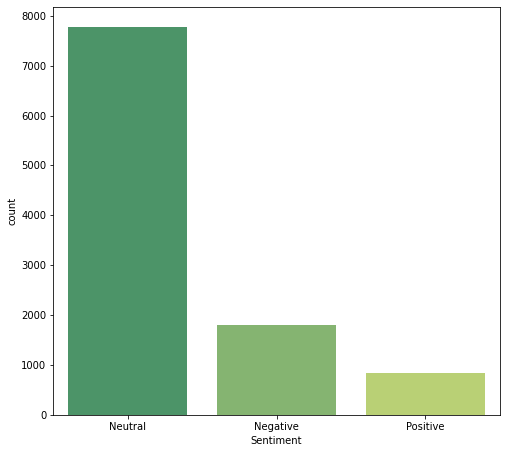

In [16]:
sns.countplot(data=df,x="Sentiment",palette="summer");

In [17]:
np.array(list(STOPWORDS))[0:5]

array(['having', 'com', 'only', 'nor', 'in'], dtype='<U10')

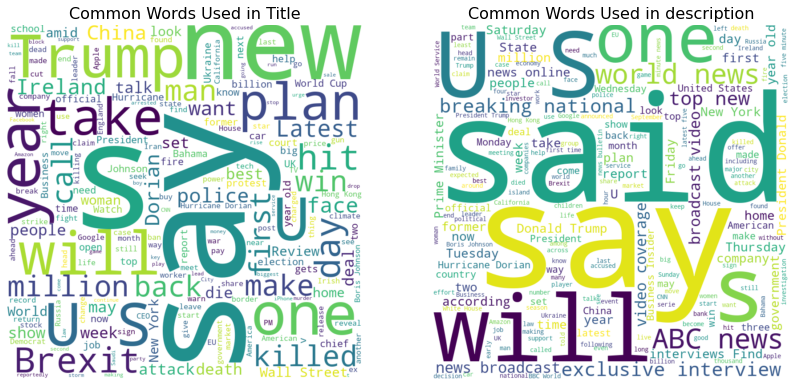

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14, 14], facecolor = None)


wc = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True,stopwords = STOPWORDS)
wc.generate("".join(df['title'].astype(str)))
ax1.axis("off")
ax1.imshow(wc, interpolation="bilinear")
ax1.set_title('Common Words Used in Title',fontsize=16);


wc2 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True,stopwords = STOPWORDS)
wc2.generate("".join(df['description'].astype(str)))
ax2.axis("off")
ax2.imshow(wc2, interpolation="bilinear")
ax2.set_title('Common Words Used in description',fontsize=16);

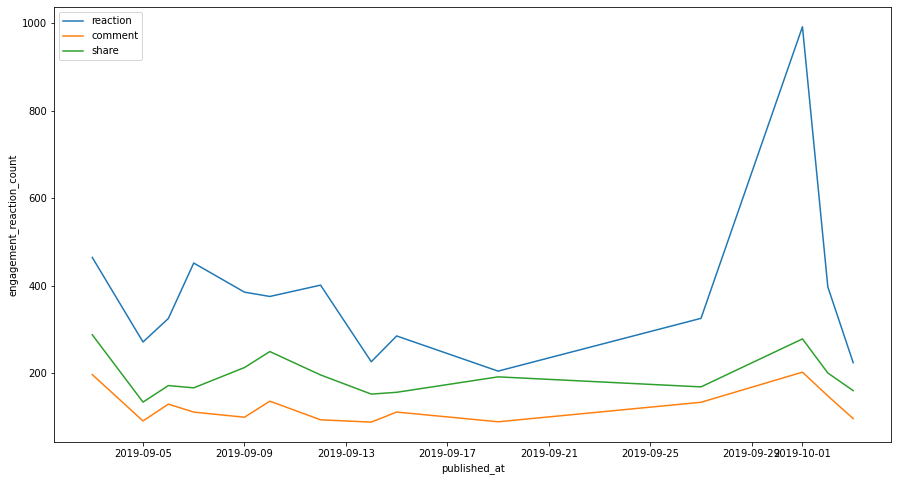

In [19]:
fig, ax1 = plt.subplots( figsize=[15, 8], facecolor = None)

b_date_mean = df.copy()
b_date_mean.published_at = pd.to_datetime(b_date_mean.published_at).dt.normalize()
b_date_mean = b_date_mean.groupby(by='published_at').mean().reset_index()

ax1 = sns.lineplot(
    data=b_date_mean, x="published_at", y="engagement_reaction_count",label = 'reaction'
)

ax1 = sns.lineplot(
    data=b_date_mean, x="published_at", y="engagement_comment_count",label = 'comment'
)

ax1 = sns.lineplot(
    data=b_date_mean, x="published_at", y="engagement_share_count", label = 'share'
)

In [20]:
df['published_at'].min(), df['published_at'].max()

(Timestamp('2019-09-03 00:00:00+0000', tz='UTC'),
 Timestamp('2019-10-03 17:49:31+0000', tz='UTC'))

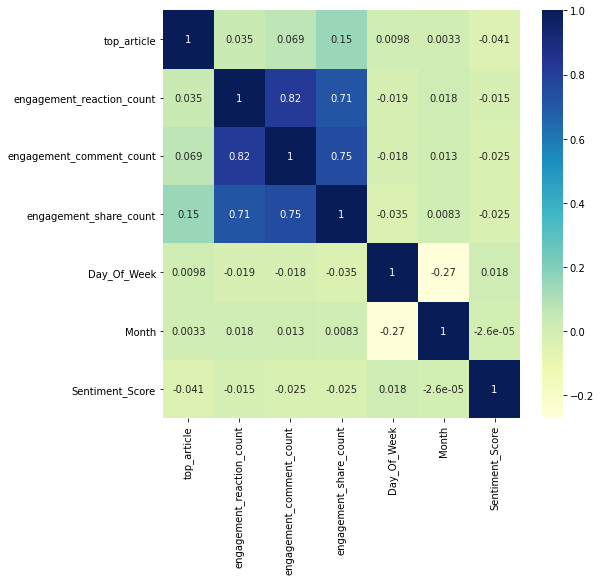

In [21]:
dataplot = sns.heatmap(df.drop(columns = ['Year','engagement_comment_plugin_count']).corr(),
                       cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [22]:
df.dropna(inplace=True)

count_vectorizer = CountVectorizer()

tfidf_vec = TfidfVectorizer(ngram_range=(1,2),
                            dtype=np.float32, 
                            sublinear_tf=True, 
                            use_idf=True, 
                            smooth_idf=True)
train_tfidf = tfidf_vec.fit_transform(df['clean_title'])



In [23]:
list_labels = df.dropna()["top_article"]
OS = SMOTE()
NM= NearMiss(version=2)
X,Y = OS.fit_resample(train_tfidf,list_labels)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.1,
                                                    stratify = Y ,
                                                    random_state=40)

modeltop = LGBMClassifier(verbose=-1,
                          learning_rate=0.5,
                          max_depth=20,
                          num_leaves=50, 
                          n_estimators=120,
                          max_bin=2000,)

scores = cross_val_score(
                 modeltop, X_train, y_train, cv=5, scoring='f1_macro')

print("Cross Validation F1 Scores : ",scores)

Cross Validation F1 Scores :  [0.89763307 0.90009108 0.90966774 0.903449   0.90217908]


In [25]:
modeltop.fit(X_train,y_train)

predtop = modeltop.predict(X_test)
print("f1 score : ",round(f1_score(predtop,y_test),2))
print("accuracy score : ",round(accuracy_score(predtop,y_test),2))

f1 score :  0.91
accuracy score :  0.91


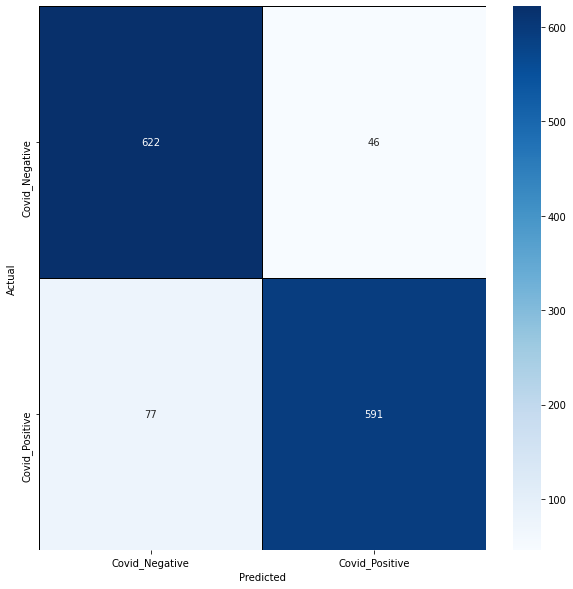

In [26]:

plt.figure(figsize = (10,10))
cm = confusion_matrix(y_test,predtop)
sns.heatmap(cm,cmap= "Blues",
            linecolor = 'black' ,
            linewidth = 1 ,
            annot = True,
            fmt='' ,
            xticklabels = ['Covid_Negative','Covid_Positive'] ,
            yticklabels = ['Covid_Negative','Covid_Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual");

In [27]:
df['Popularity_Score'] = np.log((df['engagement_reaction_count'] + \
                         df['engagement_comment_count']+\
                         df['engagement_share_count']+\
                         df['engagement_comment_plugin_count']+1))

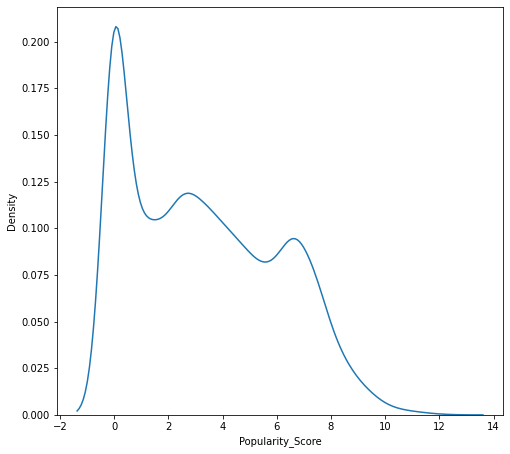

In [28]:
sns.kdeplot(df['Popularity_Score']);

In [29]:
list_labels = df.dropna()["Popularity_Score"]+0.001

X_train, X_test, y_train, y_test = train_test_split(train_tfidf,
                                                    list_labels,
                                                    test_size=0.2,
                                                    random_state=40)

model1 = LGBMRegressor(verbose=-1,
                       learning_rate=0.01,
                       max_depth=20,
                       num_leaves=50,
                       n_estimators=150)

scores = cross_val_score(
                 model1, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

print("Cross Validation RMSE Scores : ",-scores)


Cross Validation RMSE Scores :  [2.66196422 2.62136077 2.68140845 2.66181534 2.59481106]


In [30]:
model1.fit(X_train,y_train)

pred1 = model1.predict(X_test)
print("RMSE : ",round(np.sqrt(mean_squared_error(pred1,y_test)),2))

RMSE :  2.64


In [31]:
def title_score(title):
    text = tfidf_vec.transform([title])
    top_cat = modeltop.predict(text)
    pop = model1.predict(text)
    print("Top Article :" , top_cat[0].astype(bool))
    print("Popularity Score:" , round(pop[0],2))
    return top_cat,pop
    

In [32]:
df[df['top_article']==1]['title'].values[5]

'Manchin decides against running for West Virginia governor, will stay in Senate'

In [33]:
title_score("Manchin decides against running for West Virginia governor, will stay in Senate");

Top Article : True
Popularity Score: 3.39


In [34]:
title_score("Here Are the States With the Lowest COVID-19 Vaccination Rates");

Top Article : False
Popularity Score: 3.58


In [35]:
title_score("New Orleans without power as Ida delivers 'catastrophic' damage");

Top Article : True
Popularity Score: 3.19



# 结论
我们很开心地探索数据，并尝试使用不同的机器学习技术和模型。简而言之，我们已经探索了我们的数据并提供了独特的信息，这些信息可以帮助新闻机构创建更好的内容，从而获得消费者的高度关注。我们开发了机器学习模型，可以帮助作家和博主写出更好的标题。我们还发现，高人气并不意味着它会成为热门文章。

对于未来的工作，我想探索数据中的多个聚类，并使用文章的图像创建一个模型来预测受欢迎程度分数。我尝试过深度学习文本生成模型，但由于内存限制，我只能使用简单的表格模型。